In [20]:
import math
import numpy as np
from numba import njit
from matplotlib import pyplot as plt

In [45]:
def ring_sample(c: tuple, r1: float, r2: float, n: int):
    angles = np.random.uniform(0, 2*math.pi, n)
    dists = np.random.uniform(r1, r2, n)
    
    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)
    
    return np.vstack((x, y)).T


def circle_sample(c: tuple, r: float, n: int):
    angles = np.random.uniform(0, 2*math.pi, n)
    dists = np.random.uniform(0, r, n)
    
    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)
    
    return np.vstack((x, y)).T


def circle_dots(c: tuple, r: float, n: int):
    angles = np.linspace(0, 2*math.pi, n)

    x = c[0] + r * np.cos(angles)
    y = c[1] + r * np.sin(angles)

    return np.vstack((x, y)).T


def spiral_sample(c: tuple, da: float, n_loops: int):
    angles = np.arange(0, n_loops * 2 * math.pi, da)
    dists = angles.copy()

    x = c[0] + dists * np.cos(angles)
    y = c[1] + dists * np.sin(angles)

    return np.vstack((x, y)).T

In [22]:
@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> float:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return math.sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def norm_squared(x: np.ndarray) -> float:
    return np.sum(np.square(x))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return np.dot(a, b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mvcosim(m: np.ndarray, x: np.ndarray) -> np.ndarray:
    x_norm = norm(x)

    n = m.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = np.dot(m[i], x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def gate(x: np.ndarray) -> np.ndarray:
    return np.exp(-np.square(x))

In [136]:
sample1 = circle_sample((0,0), 1, 50)
sample2 = ring_sample((0,0), 5, 5.5, 100)
sample3 = ring_sample((0,0), 10, 10.5, 150)

# data = np.vstack((sample1, sample2, sample3))
data = sample2

In [137]:
n1 = 3
n2 = 5
n3 = 9

p1 = circle_dots((0, 0), 0.5, n1)[0:-1,:]
p2 = circle_dots((0, 0), 5.25, n2)[0:-1,:]
p3 = circle_dots((0, 0), 10.25, n3)[0:-1,:]

p = np.vstack((p1, p2, p3))

dist_mtrx = np.zeros((p.shape[0], p.shape[0]))

for i in range(p.shape[0]):
    for j in range(p.shape[0]):
        if i != j:
            dist_mtrx[i][j] = 1 / norm_squared(p[i]-p[j])

In [138]:
print(np.min(dist_mtrx), np.max(dist_mtrx), np.mean(dist_mtrx))

0.0 1.0 0.02196964699223907


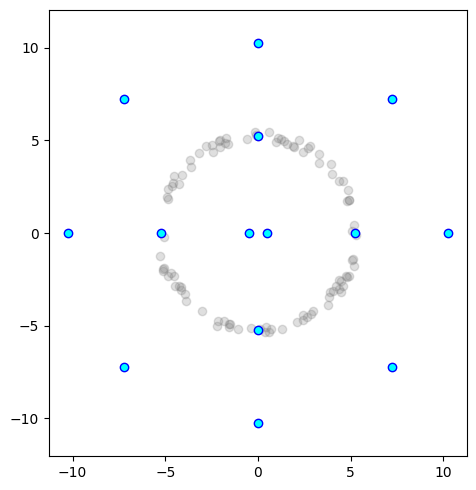

In [139]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.add_subplot()

ax.scatter(data[:,0], data[:,1], c='gray', alpha=0.25)
ax.scatter(p[:, 0], p[:, 1], c='cyan', edgecolors='blue')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [168]:
@njit(fastmath=True)
def iterate(x: np.ndarray, p: np.ndarray, d: np.ndarray, t: np.ndarray) -> np.ndarray:
    nx = x.shape[0]
    npts = p.shape[0]

    ds: np.ndarray = np.zeros(npts)
    dt: np.ndarray = np.zeros(t.shape)

    for i in range(nx):
        # u = p @ x[i]
        u = relu(p @ x[i])

        # u = mvcosim(p, x[i])
        # u = relu(mvcosim(p, x[i]))

        q = d * u
        r = np.sum(gate(t) * q, axis=0)

        ds += r
        dt += r
        # dt += np.abs(r)

    return (ds, dt)

In [171]:
m = p.shape[0]
s = np.zeros(m)
t = 10*np.ones((m, m))

alpha = 0.1
beta = 0.9

max_iter = 128
batch_size = 32
learning_rate = 1.0

n = data.shape[0]
n_batches = n // batch_size

S = []

for epoch in range(max_iter):
    idxs = np.random.permutation(n)

    S.append(s.copy().tolist())
    for i in range(n_batches):

        ibegin = i * batch_size
        iend = min((i + 1) * batch_size, n - 1)
        batch_idxs = idxs[ibegin:iend]

        ds, dt = iterate(data[batch_idxs], p, dist_mtrx, t)

        s = alpha * s + learning_rate * ds
        t = beta * t + learning_rate * dt

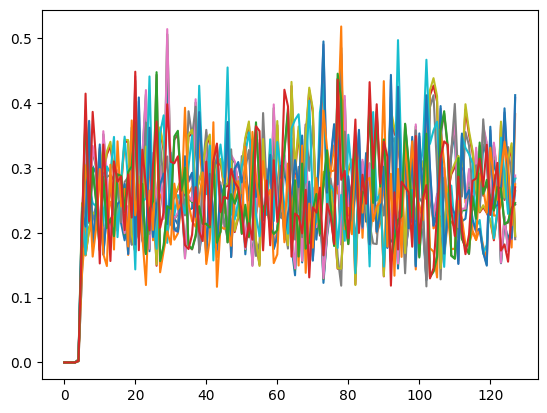

In [172]:
x = list(range(len(S)))
S = np.array(S).T

for si in S:
    plt.plot(x, si)

plt.show()